(c) Juan Gomez 2019. Thanks to Universidad EAFIT for support. This material is part of the course Introduction to Finite Element Analysis

# Solution of the equlibrium equations and post-processing

## Introduction

Having solved the problem of assembly of the global equilibrium equations for the full finite element mesh we are now ready to find the unknown nodal displacements. We won't be dealing directly with solvers but will use Python's linear algebra modules. With the nodal displacements available we will be ready to compute secondary variables (e.g., stresses and strains).In this Notebook we will also use most of the available subroutines of the finite element code **SolidsPy** (Gomez and Guarin-Zapata, 2018). Most of these subroutines follow the same structure of the implementations conducted so far. **After completing this notebook you should be able to:**

* Identify well-possed systems of global equilibrium equations within the context of the finite element method.

* Perform computations of secondary variables using as input nodal displacements.

* Understand the algorithmic aspects involved in the post-processing and visualization of typical finite element solutions.


## Global equilibrium

In previous sessions it was shown that the force equilibriun equations in terms of consistent nodal forces for the complete finite element model could be written (after discretizing the prinicple of virtual) work like:

$$
\left\{F_\sigma\right\}-\left\{F_V\right\}-\left\{F_t\right\}=0
$$

where:
* $\left\{F_\sigma\right\}$ is the global internal force vector representing element stresses: $\left\{F_\sigma\right\}=\left[K^G\right]\left\{U^G\right\}$.


* $\left\{F_V\right\}$  is the global force vector corresponding to external body forces:$F_V=\int_VN^Tf\operatorname dV$.


* $\left\{F_t\right\}$ is the global force vector corresponding to external surface tractions: $F_t=\int_SN^Tt\operatorname dS.$

At this point it is also clear that the global stiffnes matriz is built through an assembly operation of independent element contributions like:

$$
\left[K^G\right]=\bigwedge_{i=1}^{Numel} k^i .
$$

Defining a total external loads vector $RHS^G$ as:

$$
RHS^G=F_V+F_t
$$

we can write the equlibrium relationship like:

$$
\left[K^G\right]\left\{U^G\right\}=\left\{RHS^G\right\}
$$

and where $\left\{U^G\right\}$ is the vector of global nodal displacements.


If apropriate boundary conditions are imposed upon $\left[K^G\right]$ the system of equations governing the static equilibrium of the system can be solved in the unknown nodal displacements $\left\{U^G\right\}$.



With $\left\{U^G\right\}$ at hand, this global vector of unknown nodal displacements is extended into $\left\{U^C\right\}$ to include also those zero-valued prescribed displacements corresponding to the imposed displacement boundary conditions. This operation is indicated like:

$$
U^G\rightarrow U^C.
$$

In a subsequent, operation the global nodal displacements are distributed or **scattered** to each element using also the data contained in the boundary conditions array **IBC()**. This operation is schematized in the figure below and indicated by: 

$$
U^C\rightarrow U^Q
$$

where specific displacements from $U^C$ are extracted to form the displacemnts vector from element $Q$.

<center><img src="img/scatter.png" alt="files" style="width:500px"></center>


In the final post-processing step we proceed one element at a time and use the local nodal displacements vector $U^Q$ to compute strains and stresses using the strain-displacement interpolator $\left[B\right]$ and the constitutive matrix $C$ as follows:


$$
\left\{\varepsilon\right\}\;=\left[B\right]\left\{U^Q\right\}
$$

and

$$
\left\{\sigma\right\}\;=\left[C\right]\left[B\right]\left\{U^Q\right\}.
$$

**Questions:**

**(i) For element $2$ in the simple mesh problem shown in the figure plot a scattering diagram like the one shown in the figure above.**


## A complete solution step wih SolidsPy.


We now use subroutines implemented in previous notebooks and also available in the Python code **SolidsPy** to solve the simple mesh problem studied so far and shown in the figure.

<center><img src="img/assembled.png" alt="files" style="width:500px"></center>

The basic solution steps, after reading the input files correspond to:

* (i) Determination of the boundary conditions array and assembly operator.

* (ii) Assembly of the global matrix of stiffness coeffcients and global external loads vector.

* (iii) Solution of the system of equations.

* (iv) Post-processing.

**Question:**

**¿ If the plate shown in the figure is loaded by vertical nodal forces applied at the top surface indicate a minimum set of prescribed displacement boundary conditions for the system to have a unique solution?**

### SolidsPy modules

To execute most of this notebook the Python finite element code [SolidsPy](https://github.com/AppliedMechanics-EAFIT/SolidsPy) must be properly installed. Here we will import 3 modules, namely:

* assemutil containing assembling subroutines similar to those implemented in previous notebooks.

* solutil containing calls to solvers of linear systems of equations.

* postprocessor containg a series of subroutines for secondary calculation and visualization of finite element solutions.


In [5]:
import sys
import os

# Construct the full path to the source code directory relative to the current working directory
source_code_path = os.path.join(os.getcwd(), "..", "solidspy")

# Add the source code directory to the Python path
sys.path.append(source_code_path)


In [6]:
%matplotlib inline        
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
import assemutil as ass
import postprocesor as pos
import solutil as sol

In [7]:
def readin():
    nodes    = np.loadtxt('files/' + 'Gnodes.txt', ndmin=2)
    mats     = np.loadtxt('files/' + 'Gmater.txt', ndmin=2)
    elements = np.loadtxt('files/' + 'Gelements.txt', ndmin=2, dtype=int)
    loads    = np.loadtxt('files/' + 'Gloads.txt', ndmin=2)

    return nodes, mats, elements, loads


nodes, mats, elements, loads = readin()
elements

array([[0, 1, 0, 0, 4, 8, 7],
       [1, 1, 0, 4, 1, 5, 8],
       [2, 1, 0, 7, 8, 6, 3],
       [3, 1, 0, 8, 5, 2, 6]])

In [8]:
DME, IBC, neq = ass.DME(nodes, elements)
DME

array([[ 0, -1, -1, -1, 12, 13, 10, 11,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [-1, -1,  1, -1,  6,  7, 12, 13,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [10, 11, 12, 13,  8,  9,  4,  5,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [12, 13,  6,  7,  2,  3,  8,  9,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0]])

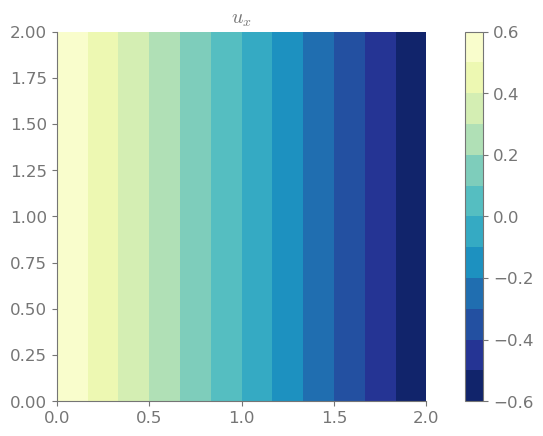

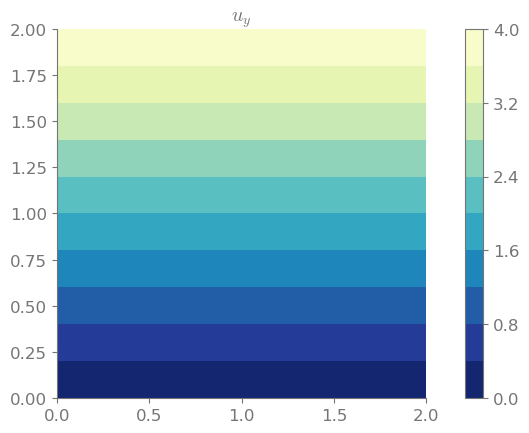

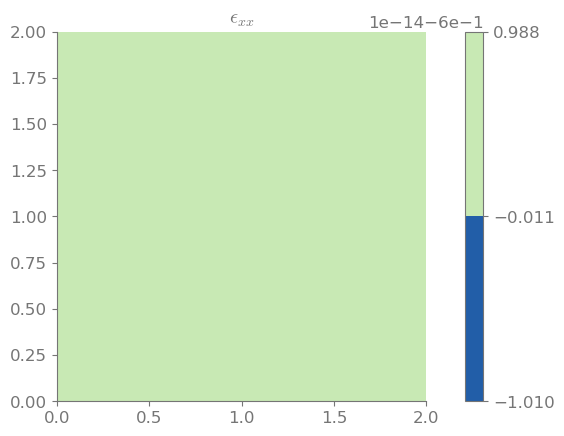

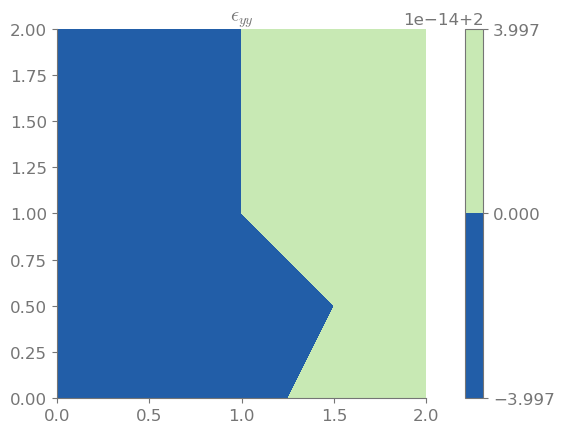

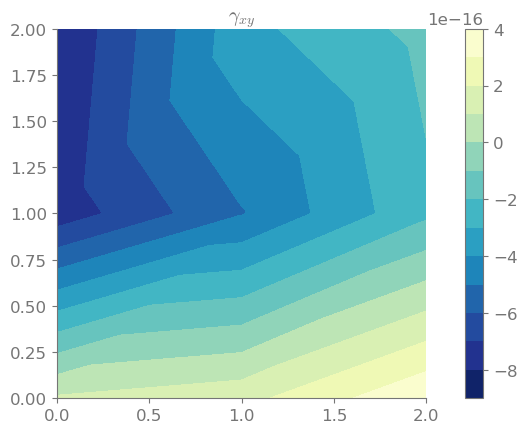

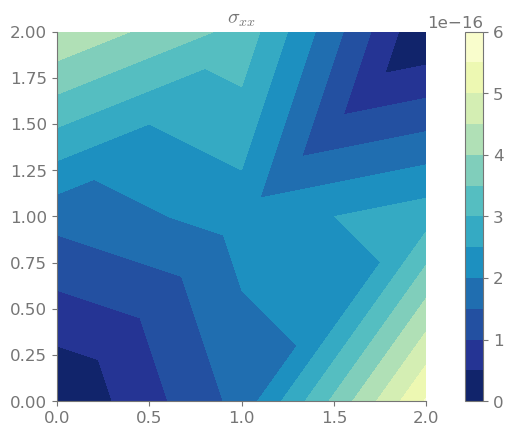

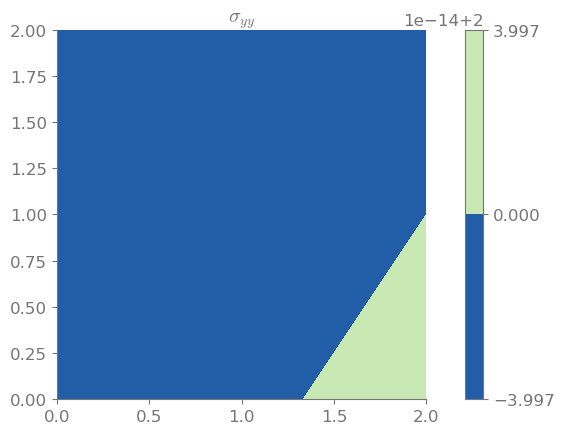

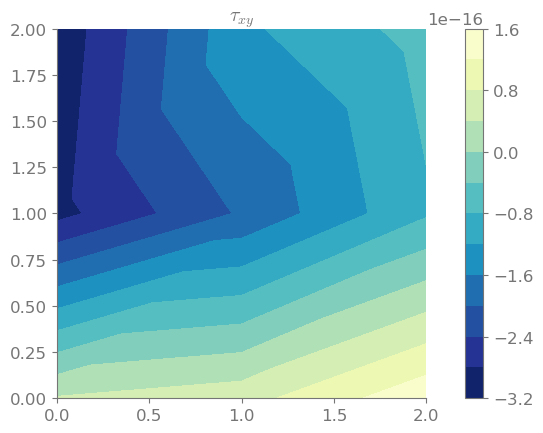

In [9]:
KG = ass.assembler(elements, mats, nodes, neq, DME)
RHSG = ass.loadasem(loads, IBC, neq)
UG = sol.static_sol(KG, RHSG)
UC = pos.complete_disp(IBC, nodes, UG)
E_nodes, S_nodes = pos.strain_nodes(nodes, elements, mats, UC)
pos.fields_plot(elements, nodes, UC, E_nodes=E_nodes, S_nodes=S_nodes)

### Glossary of terms

**Global equlibrium:** Satic equlibrium equations in terms of internal and external forces for the complete finite element model.

**Postprocessing:** Set of computational tasks aied at producing visualizations of primary and secondary data using as input the found nodal point displacements.

**Scattering process:** Procedure that distributes nodal point displacements from the global displacement vector to each element in the mesh.

**Solubility conditions:** Minimum reuirements in terms of displacement boundary conditions to guarantee a unique solution of the discrete finite elment equlibrium equations.

## Class activity.

* (i) Write a pseudo-code to perform the scattering process where the nodal displacements from the global vector are passed to each element. Define the input and output parameters, clearly.

* (ii) Identify the subroutine (or piece of code) within the program **SolidsPy** where the scattering process takes place.

* (iii) Refine the mesh for the example problem by adding more elements while keeping the same size for the computational domain and indicate the changes in the displacement for the top surface.


### References

* Bathe, Klaus-Jürgen. (2006) Finite element procedures. Klaus-Jurgen Bathe. Prentice Hall International.

* Juan Gómez, Nicolás Guarín-Zapata (2018). SolidsPy: 2D-Finite Element Analysis with Python, <https://github.com/AppliedMechanics-EAFIT/SolidsPy>.